In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import fmnist
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
train_loader, test_loader = fmnist()

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 125)
        self.fc4 = nn.Linear(125, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(500)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        if self.batchnorm:
            x = self.bn(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
model = Net(False, False).to(device)

In [6]:
def train(epoch, model):
    
    print('Training epoch: {}\n'.format(epoch))
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()

In [7]:
def test(model, loader, dataset='test'):
    test_size = len(loader.sampler)
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += model.loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    test_loss /= test_size
    acc = correct / test_size
    
    if dataset == 'train':
        train_losses.append(test_loss)
        train_acc.append(acc)
    else:
        test_losses.append(test_loss)
        test_acc.append(acc)
    
    print(f'{dataset.capitalize()} loss {test_loss}\t{dataset.capitalize()} accuracy {acc:.4f}\n')

In [8]:
train_losses = []
test_losses = []

train_acc = []
test_acc = []

for epoch in range(1, 51):
    model.train()
    train(epoch, model)
    model.eval()
    test(model, train_loader, 'train')
    test(model, test_loader)

Training epoch: 1

Train loss 0.40171396147410077	Train accuracy 0.8557

Test loss 0.43793206462860107	Test accuracy 0.8424

Training epoch: 2

Train loss 0.3449521506468455	Train accuracy 0.8754

Test loss 0.39109676437377927	Test accuracy 0.8612

Training epoch: 3

Train loss 0.31648362226486204	Train accuracy 0.8866

Test loss 0.3710314164161682	Test accuracy 0.8696

Training epoch: 4

Train loss 0.3240796083291372	Train accuracy 0.8785

Test loss 0.38919131011962893	Test accuracy 0.8577

Training epoch: 5

Train loss 0.283454167064031	Train accuracy 0.8945

Test loss 0.36013953289985656	Test accuracy 0.8699

Training epoch: 6

Train loss 0.25459599646727243	Train accuracy 0.9066

Test loss 0.33578210978507994	Test accuracy 0.8777

Training epoch: 7

Train loss 0.24627740783691407	Train accuracy 0.9090

Test loss 0.33739367492198946	Test accuracy 0.8778

Training epoch: 8

Train loss 0.24026404446760813	Train accuracy 0.9126

Test loss 0.34385442895889284	Test accuracy 0.8786

Train

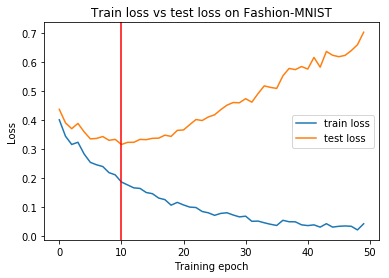

In [9]:
plt.plot(range(len(train_losses)), train_losses, label='train loss')
plt.plot(range(len(test_losses)), test_losses, label='test loss')
plt.axvline(x=np.argmin(test_losses), color='r', linestyle='-')
plt.xlabel('Training epoch')
plt.ylabel('Loss')
plt.title('Train loss vs test loss on Fashion-MNIST')
plt.legend();

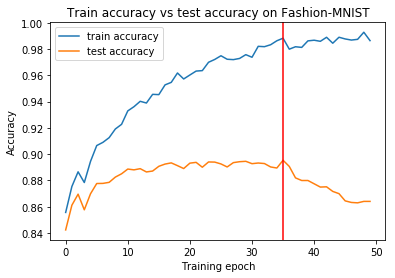

In [24]:
plt.plot(range(len(train_acc)), train_acc, label='train accuracy')
plt.plot(range(len(test_acc)), test_acc, label='test accuracy')
plt.axvline(x=np.argmax(test_acc), color='r', linestyle='-')
plt.xlabel('Training epoch')
plt.ylabel('Accuracy')
plt.title('Train accuracy vs test accuracy on Fashion-MNIST')
plt.legend();